This a final model training n testing file 
Note : run this file  Kaggle platform for quick result

In [1]:
import pickle
import numpy as np


- caption_dict -> Caption_description.pkl
- train_caption -> train_description.pkl
- word_to_idx -> Word_to_idx.pkl
- idx_to_word -> Idx_to_word.pkl
- emb_mat -> embedding_matrix.npy

In [2]:
with open('/kaggle/input/pklfiles/Caption_description.pkl', 'rb') as f:
    caption_dict = pickle.load(f)
    
with open('/kaggle/input/pklfiles/train_description.pkl', 'rb') as f:
    train_caption = pickle.load(f)
    
with open('/kaggle/input/pklfiles/Word_to_idx.pkl','rb') as f:
    word_to_idx = pickle.load(f)
    
with open('/kaggle/input/pklfiles/Idx_to_word.pkl','rb') as f:
    idx_to_word = pickle.load(f)
    
with open('/kaggle/input/pklfiles/embedding_matrix.npy','rb') as f:
    emb_mat = np.load(f)

In [3]:
emb_mat.shape

(1958, 50)

In [4]:
# Find max length caption

max_length = 0
for img_name in train_caption.keys():
    for caption in train_caption[img_name]:
        
        max_length = max(max_length,len(caption.split()))
        
print(max_length)

35


In [5]:
vocab_size =len(word_to_idx)
print(vocab_size)

1958


In [6]:
# Import extracted training images features
with open('/kaggle/input/pklfiles/encoded_train_features.pkl','rb') as f:
    encoding_train = pickle.load(f)

### Data Generator

- This function will predict next word from past sequence of words
    - Example
        - This
        - This is
        - This is a
        - This is a ball
        

`Note:` We will not pass word, inspite we will pass interger value which will represnt word

In [7]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [8]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def data_generator(train_caption, encoding_train, word_to_idx, batch_size, max_length, vocab_size):
    x1, x2, y = [], [], []  # Inputs and outputs
    n = 0  # Counter for batch size
    
    while True:
        for key, caption_list in train_caption.items():
            encoded_img = encoding_train[key]  # Encoded image features
            
            for caption in caption_list:
                seq = [word_to_idx[word] for word in caption.split() if word in word_to_idx]
                
                for i in range(1, len(seq)):  # Start from index 1
                    xi = seq[:i]
                    yi = seq[i]
                    
                    xi = pad_sequences([xi], maxlen=max_length, padding='post')[0]
                    yi = to_categorical([yi], num_classes=vocab_size+1)[0]
                    
                    x1.append(encoded_img)
                    x2.append(xi)
                    y.append(yi)
                    
                    if len(x1) == batch_size:
                        yield (
                            (tf.convert_to_tensor(x1, dtype=tf.float32), 
                             tf.convert_to_tensor(x2, dtype=tf.float32)),
                            tf.convert_to_tensor(y, dtype=tf.float32)
                        )
                        x1, x2, y = [], [], []  # Reset the batch


In [9]:
def create_dataset(train_caption, encoding_train, word_to_idx, batch_size, max_length, vocab_size):
    feature_shape = encoding_train[list(encoding_train.keys())[0]].shape

    return tf.data.Dataset.from_generator(
        lambda: data_generator(train_caption, encoding_train, word_to_idx, batch_size, max_length, vocab_size),
        output_signature=(
            (
                tf.TensorSpec(shape=(None, *feature_shape), dtype=tf.float32),  # x1: image features
                tf.TensorSpec(shape=(None, max_length), dtype=tf.float32),     # x2: padded sequences
            ),
            tf.TensorSpec(shape=(None, vocab_size+1), dtype=tf.float32),       # Targets: one-hot labels
        )
    )


In [10]:
dataset = create_dataset(train_caption, encoding_train, word_to_idx, batch_size=3, max_length=35, vocab_size=1958)

for inputs, targets in dataset.take(1):
    print("Inputs:")
    print(f"x1 shape: {inputs[0].shape}")
    print(f"x2 shape: {inputs[1].shape}")
    print("Targets:")
    print(f"Targets shape: {targets.shape}")


Inputs:
x1 shape: (3, 2048)
x2 shape: (3, 35)
Targets:
Targets shape: (3, 1959)


In [11]:
# def data_generator(train_caption, encoding_train, word_to_idx, batch_size, max_length):
#     x1, x2, y = [], [], []
#     n = 0
#     while True:
#         for key, caption_list in train_caption.items():
#             n += 1
#             encoded_img = encoding_train[key]
#             for caption in caption_list:
#                 seq = [word_to_idx[word] for word in caption.split() if word in word_to_idx.keys()]
#                 for i in range(1, len(seq)):
#                     xi = seq[:i]
#                     yi = seq[i]
                    
#                     xi = pad_sequences([xi], maxlen=max_length, value=0, padding='post')[0]
#                     yi = to_categorical([yi], num_classes=vocab_size + 1)[0]

#                     x1.append(encoded_img)
#                     x2.append(xi)
#                     y.append(yi)
                    
#                 if n == batch_size:
#                     yield (
#                         [np.array(x1, dtype=np.float32), np.array(x2, dtype=np.float32)],
#                         np.array(y, dtype=np.float32)
#                     )
#                     x1, x2, y = [], [], []
#                     n = 0


### Model Architecture

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
import os
import glob

`The Model Architecture is not a Sequential model`

In [13]:
# To handle Images
img_input = Input(shape=(2048,))     #sahpe of extracted features of images, is taken as input
img_inp1 = Dropout(0.3)(img_input)
img_inp2 = Dense(256,activation='relu')(img_inp1)   #coverting input dim(2048) to 256dim

# To handle Cptions
caption_input = Input(shape=(max_length,))          #Length of the vocab is the input shape o captions
cap_inp1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(caption_input)
cap_inp2 = Dropout(0.3)(cap_inp1)
cap_inp3 = LSTM(256)(cap_inp2)

In [14]:
# main Model
# Here we have to make a decoder which will take input from two concatenated vectors

decoder1 = add([img_inp2,cap_inp3]) #this layer will take pne input from the image and the other is from the captions
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size+1,activation='softmax')(decoder2)

#  Combine Model
model = Model([img_input,caption_input],outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 35)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 2048)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 35, 50)         │         97,900 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 35, 50)         │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 35)             │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        314,368 │ dropout_1[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense[0][0],           │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1959)           │        503,463 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,506,067 (5.75 MB)

 Trainable params: 1,506,067 (5.75 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
emb_mat.shape == (vocab_size, 50)


True

In [16]:
print("emb_mat.shape:", emb_mat.shape)

emb_mat.shape: (1958, 50)


In [17]:
print("vocab_size:", vocab_size)  

vocab_size: 1958


In [18]:
vocab_size = emb_mat.shape[0]

In [19]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)

In [20]:
# Set embedding layer weights
model.layers[2].set_weights([emb_mat])   #we are setting embedding layers weight which we get from embedding matrix
model.layers[2].trainable = False
# embedding_layer.set_weights([emb_mat])
# embedding_layer.trainable = False

In [21]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [22]:
for layer in model.layers:
    print(layer.name)

input_layer_1
input_layer
embedding
dropout
dropout_1
dense
lstm
add
dense_1
dense_2


In [23]:
# Train model

batch_size = 3
epochs = 20
images_per_batch = 3
steps = len(train_caption)//(images_per_batch*10)

try:
    os.mkdir('./model_weights')
    print('Directory Created')
except:
    print('Directory exists')
    files = glob.glob('./model_weights/*')
    for f in files:
        os.remove(f)
    
    
def train():
    for i in range(epochs):
        # Pass vocab_size as an argument to data_generator
        generator = data_generator(train_caption, encoding_train, word_to_idx, batch_size, max_length,vocab_size)
        h = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
        model.save(f'./model_weights/model_{i+1}.h5')


Directory Created


In [24]:
train()
# model.fit(dataset, epochs=5, steps_per_epoch=100, verbose=1)


200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 6.0842
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.9357
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.6005
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3204
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1532
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.8498
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.7323
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.4041
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2009
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1273
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.9808
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7773
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5849
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5076
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4226
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2472
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0924
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss:

In [27]:
with open('/kaggle/input/pklfiles/encoded_test_feature.pkl','rb') as f:
    encoding_test = pickle.load(f)

In [41]:
max_length = 33

In [38]:
import matplotlib.pyplot as plt

In [50]:
def predict_caption(caption):
    
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [word_to_idx[word] for word in in_text.split() if word in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_length,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = np.argmax(ypred)
        word = idx_to_word[ypred]
        in_text += (' '+word)
        
        if word == 'endseq':
            break
            
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
        
    return final_caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
little boy in red shirt is on the the


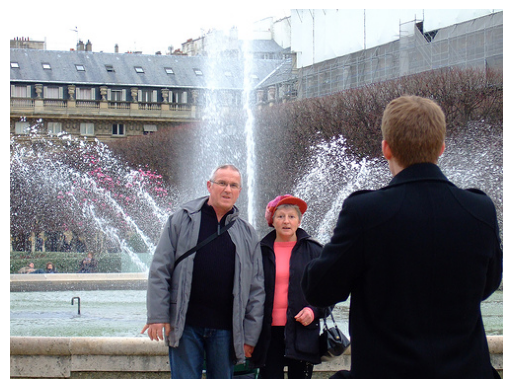

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
the of dogs in in the red shirt and the snow


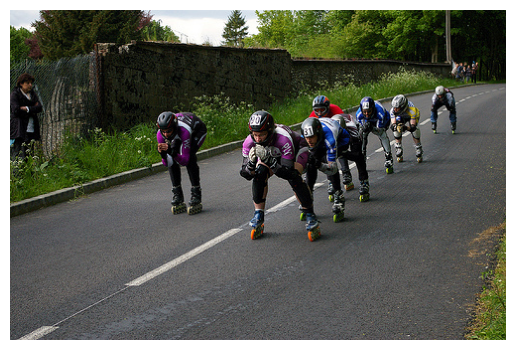

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
the of dogs in in the the


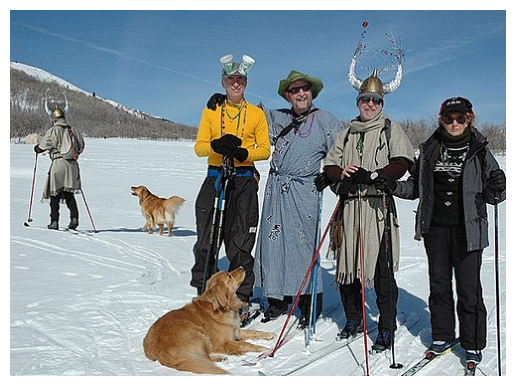

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
the little is in the red shirt and white shirt and the the


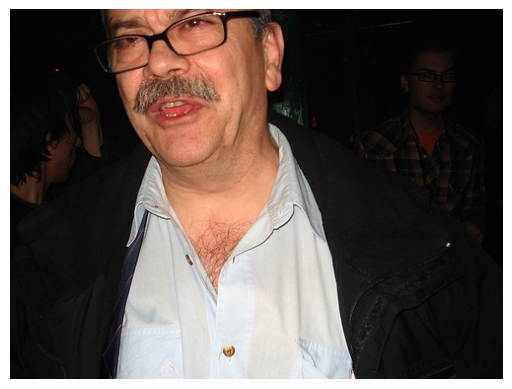

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
the little is in the red shirt and the of of the


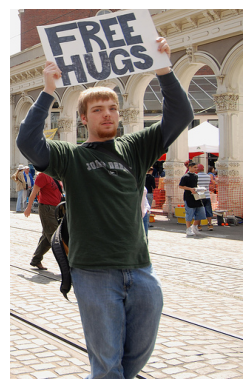

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
the dogs is in in the street


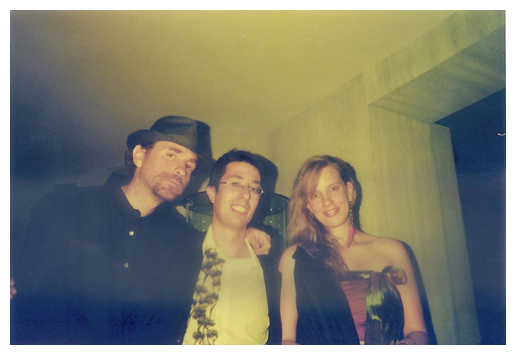

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
the of dogs in in the the


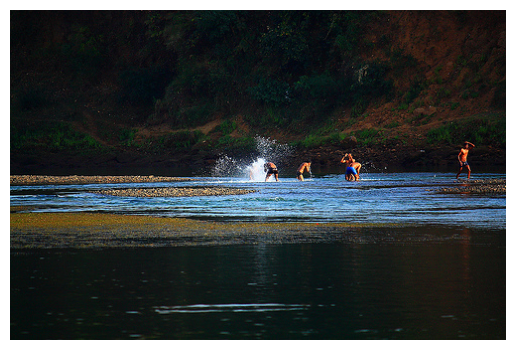

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
the of dogs in in green shirt and white and


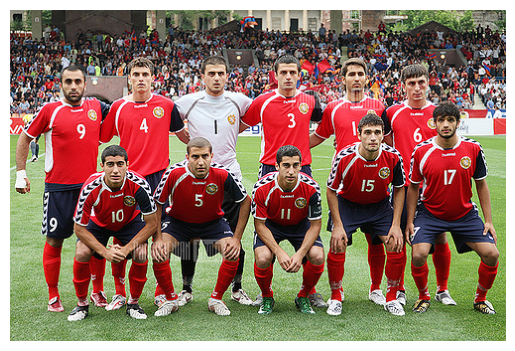

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
man wearing in red shirt and the


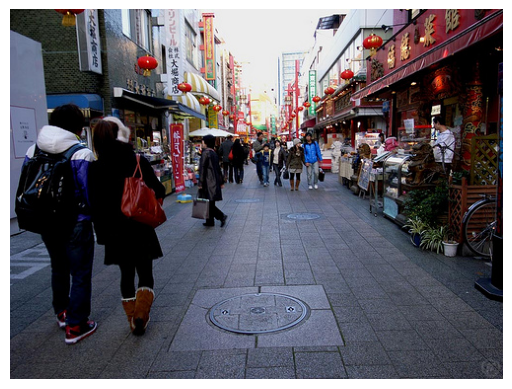

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
the dogs is in in the street


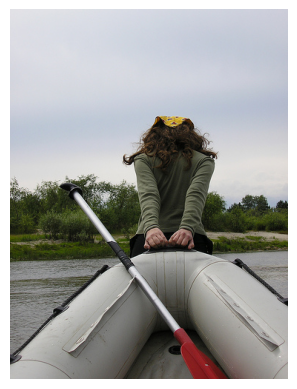

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
little boy in red shirt is on the the while while


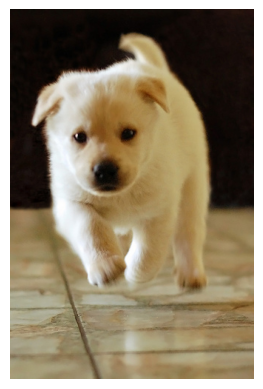

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
the little is in the red shirt and white shirt and the camera


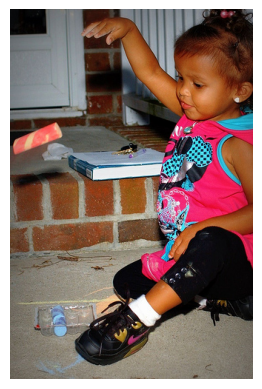

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
the little is in the red shirt and white and to the of the


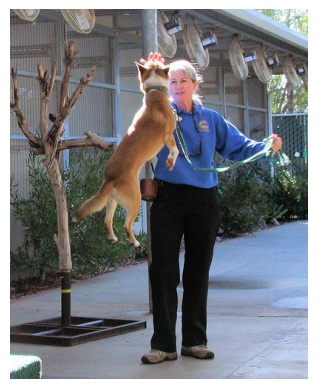

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
the dogs is in the the


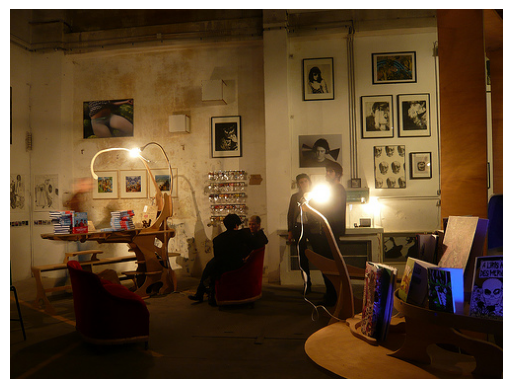

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
the of dogs in in the the


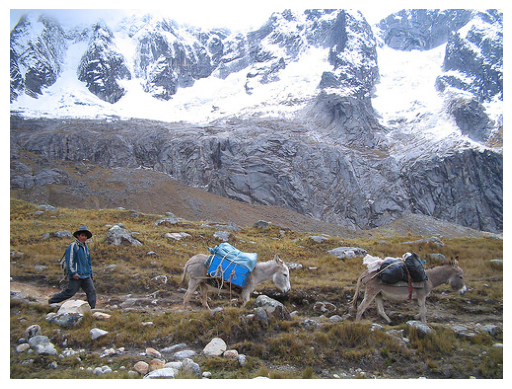

In [53]:
for i in range(15):
    idx = np.random.randint(1,1000)
    images = list(encoding_test.keys())
    img = images[idx]
    photo = encoding_test[img].reshape((1,2048))
    
    caption = predict_caption(photo)
    image = plt.imread('/kaggle/input/flickr8k/Images/'+img)
    print(caption)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

### Note: Use various methods to reduce error will increase accuracy.